In [39]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import copy

# read weather regimes

In [40]:
names_wrs = ["Polar High", "Pacific Trough", "Pacific Ridge", "Alaskan Ridge", "Atlantic Ridge" ,"No WR"]

In [41]:
from scipy.stats import theilslopes
import statsmodels.api as sm

In [42]:
files_lens2 = np.sort(glob.glob('../ProcessZ500/labels_lens2/*.csv'))

dic_labels_lens2 = {}

for file_temp in files_lens2:
    labels_temp = pd.read_csv(file_temp, parse_dates=True, index_col=0, 
                              names=['WR','distances','corr'], skiprows=1)#[['WR']]
    labels_temp['season'] = labels_temp.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    labels_temp['season'] = labels_temp['season'].map(season_map)
    labels_temp.loc[labels_temp['corr']<=0.2,'WR']=np.unique(labels_temp['WR'])[-1]
    dic_labels_lens2[file_temp.split('labels_')[-1][:-4]] = labels_temp

dic_events_lens2 = {}

for file_temp in files_lens2:
    # Compute Overall Frequency of Each Class
    df_labels = copy.deepcopy(dic_labels_lens2[file_temp.split('labels_')[-1][:-4]])

    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max','corr':'mean','distances':'mean'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    df_events['season'] = df_events.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON
    # Map season numbers to season names
    season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    df_events['season'] = df_events['season'].map(season_map)
    df_events['year'] = df_events.index.year
    # df_events = df_events[df_events['duration']>=4]
    dic_events_lens2[file_temp.split('labels_')[-1][:-4]] = df_events

/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/2115786177.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/2115786177.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_labels['start_date'].fillna(method='ffill', inplace=True)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/2115786177.py:25: FutureWarning: A value

In [43]:
N=30
from multiprocessing import Pool

# Function to process each file and return results
def process_file(file_temp):
    print(file_temp)
    key = file_temp.split('labels_')[-1][:-4]
    dic_stats = {}
    dic_dfs = {}

    start_year = dic_labels_lens2[key].index.year[0] + (N-1)
    end_year = dic_labels_lens2[key].index.year[-1]
    
    for wr in range(6):
        df_temp = copy.deepcopy(dic_events_lens2[key])
        df_temp = df_temp[(df_temp['season'] == 'Winter')|(df_temp['season'] == 'Spring')]
        df_temp = df_temp[df_temp['WR'] == wr]
        
        dic_stats_temp = {
            'mean': [],
            'std': [],
            'p90': [],
            'p10': [],
            'p95': [],
            'p05': [],
            'n_events': [],
            'n_days': []
        }
        
        for year in range(start_year, end_year + 1):
            df_temp_temp = df_temp.loc[str(year-N+1):str(year)]['duration']
            dic_stats_temp['mean'].append(df_temp_temp.mean())
            dic_stats_temp['std'].append(df_temp_temp.std())
            dic_stats_temp['p90'].append(df_temp_temp.quantile(0.9))
            dic_stats_temp['p10'].append(df_temp_temp.quantile(0.1))
            dic_stats_temp['p95'].append(df_temp_temp.quantile(0.95))
            dic_stats_temp['p05'].append(df_temp_temp.quantile(0.05))

            dic_stats_temp['n_events'].append(len(df_temp_temp) / 30)
            dic_stats_temp['n_days'].append(df_temp_temp.sum() / (30 * 365 / 2))
        
        df_stats_temp = pd.DataFrame(dic_stats_temp, index=np.arange(start_year, end_year + 1))
        dic_stats[f'wr{wr}'] = df_stats_temp
        dic_dfs[f'wr{wr}'] = df_temp
    
    return key, dic_stats, dic_dfs

# Use multiprocessing to parallelize the processing
if __name__ == '__main__':
    dic_stats_durations_lens2 = {}
    dic_dfs_durations_lens2 = {}

    with Pool() as pool:
        results = pool.map(process_file, files_lens2)

    # Collect results into the final dictionaries
    for key, dic_stats, dic_dfs in results:
        dic_stats_durations_lens2[key] = dic_stats
        dic_dfs_durations_lens2[key] = dic_dfs

    # You can now use dic_stats_durations_lens2 and dic_dfs_durations_lens2 as needed

names_models = np.array([file_temp.split('labels_')[-1][:-4] for file_temp in files_lens2])

../ProcessZ500/labels_lens2/df_labels_LE2-1001.001_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1051.003_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1021.002_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1011.001_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1031.002_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1061.004_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1041.003_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1071.004_smbb.csv
../ProcessZ500/labels_lens2/df_labels_LE2-1081.005_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1091.005_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1111.006_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1101.006_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1131.007_smbb.csv../ProcessZ500/labels_lens2/df_labels_LE2-1121.007_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1161.009_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1141.008_cmip6.csv../ProcessZ500/labels_lens2/df_labels_LE2-1151

In [44]:
wr = 1
dic_yearly_freqs = {}

for name_exp in names_models:
    wr=1
    
    # Plot metrics
    df_events_temp = copy.deepcopy(dic_events_lens2[name_exp][dic_events_lens2[name_exp]['WR']==wr])
    df_events_temp = df_events_temp[df_events_temp.index.month.isin([12,1, 2, 3, 4, 5])]
    is_leap_year = df_events_temp.index.is_leap_year
    total_days_in_year = np.where(is_leap_year, 366, 365)
    
    # Convert DatetimeIndex to years in decimals
    df_events_temp['year_decimal'] = (df_events_temp.index.year + (df_events_temp.index.dayofyear / total_days_in_year)).values
    
    yearly_count = df_events_temp.groupby('year').sum()['duration']
    yearly_count = yearly_count.reindex(index=np.arange(1948,2101))
    yearly_count = 100*yearly_count/(365/2)
    yearly_count=yearly_count.fillna(0)
    dic_yearly_freqs[name_exp] = yearly_count

In [47]:
def calculate_pixel_correlation_vectorized(data_array, time_series):
    """
    Calculates Pearson correlation between each pixel and a time series (vectorized).

    Args:
        data_array (xr.DataArray): DataArray with 'year', 'lat', and 'lon' dimensions.
        time_series (pd.Series): Pandas Series with the same index as the 'year' coordinate.

    Returns:
        xr.Dataset: Dataset with correlation coefficients and p-values.
    """

    # Calculate means and standard deviations
    data_mean = data_array.mean(dim='year')
    time_mean = time_series.mean()
    data_std = data_array.std(dim='year')
    time_std = time_series.std()

    # Calculate covariance
    time_series_expanded = time_series.values[:, np.newaxis, np.newaxis] # add 2 new dimensions
    covariance = np.nanmean(((data_array - data_mean).values * (time_series_expanded - time_mean)),axis=0)#.mean(axis=0)
    # 
    # # # Calculate correlation coefficients
    correlation_coeffs = covariance / (data_std.values * time_std)

    correlation_coeffs = xr.DataArray(
        correlation_coeffs,
        coords=data_mean.coords,
        dims=data_mean.dims
    )
    # Calculate t-statistic and p-values
    n = data_array.sizes['year']
    t_statistic = correlation_coeffs * np.sqrt((n - 2) / (1 - correlation_coeffs**2))
    p_values = xr.DataArray(
        2 * (1 - xr.DataArray(np.abs(t_statistic))),
        coords=data_mean.coords,
        dims=data_mean.dims
    )

    return xr.Dataset({'correlation': correlation_coeffs, 'p_value': p_values})

# compute

In [1]:
path_temp_files = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS2_higherthanp90_v2/'

In [6]:
filenames = np.sort(glob.glob(f'{path_temp_files}*'))

In [18]:
names_exps = np.array([filenames[i].split('p90')[-1][1:-3] for i in range(len(filenames))])

In [20]:
filei=0

In [70]:
diffs = []
diffs_percent = []
corrs = []
for filei in range(len(names_exps)):
    higherthanp90_temp = xr.open_dataset(filenames[filei])
    name_exp_temp = names_exps[filei]
    
    temp_temp = higherthanp90_temp.sel(time=slice('1994','2023'))
    composite_past = temp_temp.sum('time')/30
    temp_temp = higherthanp90_temp.sel(time=slice('2071','2100'))
    composite_present = temp_temp.sum('time')/30
    diff = composite_present-composite_past
    diff_percent = diff/composite_past
    yearly_anoms = higherthanp90_temp.groupby('time.year').sum(dim='time')
    
    corr_temp = calculate_pixel_correlation_vectorized(\
        yearly_anoms.sel(year=slice('2024','2100')).TREFHTMX, \
        dic_yearly_freqs[name_exp_temp].loc['2024':'2100'])

    diffs.append(diff)
    diffs_percent.append(diff_percent)
    corrs.append(corr_temp)

/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: R

In [73]:
diffs = xr.concat(diffs,dim='exp')
diffs_percent = xr.concat(diffs_percent,dim='exp')
corrs = xr.concat(corrs,dim='exp')

In [74]:
diffs.to_netcdf('diffs_models_extremes/diffs_lens_higherthanp90.nc')
diffs_percent.to_netcdf('diffs_models_extremes/diffs_percent_lens_higherthanp90.nc')
corrs.to_netcdf('corrs_models_extremes/corrs_percent_lens_higherthanp90.nc')

# just for PT

In [125]:
diffs = []
diffs_percent = []
corrs = []
for filei in range(len(names_exps)):
    higherthanp90_temp = xr.open_dataset(filenames[filei])
    name_exp_temp = names_exps[filei]
    
    df_temp = dic_labels_lens2[name_exp_temp]['1994':'2023']
    temp_temp = higherthanp90_temp.sel(time=df_temp[df_temp['WR']==1].index)
    composite_past = temp_temp.sum('time')/30
    
    df_temp = dic_labels_lens2[name_exp_temp]['2071':'2100']
    temp_temp = higherthanp90_temp.sel(time=df_temp[df_temp['WR']==1].index)
    composite_present = temp_temp.sum('time')/30
    
    diff = composite_present-composite_past
    diff_percent = diff/composite_past
    
    diffs.append(diff)
    diffs_percent.append(diff_percent)

    df_temp = dic_labels_lens2[name_exp_temp].loc['1948':]
    temp_temp = higherthanp90_temp.sel(time=df_temp[df_temp['WR']==1].index)
    
    yearly_anoms = temp_temp.groupby('time.year').sum(dim='time')
    
    corr_temp = calculate_pixel_correlation_vectorized(\
        yearly_anoms.sel(year=slice('2024','2100')).TREFHTMX, \
        dic_yearly_freqs[name_exp_temp].loc['2024':'2100'])
    corrs.append(corr_temp)

/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: R

In [127]:
diffs = xr.concat(diffs,dim='exp')
diffs_percent = xr.concat(diffs_percent,dim='exp')
corrs = xr.concat(corrs,dim='exp')

In [128]:
diffs.to_netcdf('diffs_models_extremes/diffs_lens_higherthanp90_pt.nc')
diffs_percent.to_netcdf('diffs_models_extremes/diffs_percent_lens_higherthanp90_pt.nc')
corrs.to_netcdf('corrs_models_extremes/corrs_percent_lens_higherthanp90_pt.nc')

# Warm spells

In [135]:
def find_start_durations(data):
    """Finds durations of consecutive 1s and assigns them to start times."""
    durations = np.zeros_like(data, dtype=int)  # Initialize durations array
    for lat_idx in range(data.shape[1]):
        for lon_idx in range(data.shape[2]):
            time_series = data[:, lat_idx, lon_idx]
            if np.any(time_series):
                diffs = np.diff(np.concatenate(([0], time_series, [0])))
                starts = np.where(diffs == 1)[0]
                ends = np.where(diffs == -1)[0]
                for start, end in zip(starts, ends):
                    durations[start, lat_idx, lon_idx] = end - start
    return durations

In [159]:
path_spells = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS2_warmspells/'

In [163]:
diffs = []
diffs_percent = []
corrs = []
for filei in range(len(names_exps)):
    higherthanp90_temp = xr.open_dataset(filenames[filei])
    name_exp_temp = names_exps[filei]
    
    # Assuming 'MaxTemp' is your xarray.DataArray
    durations = find_start_durations(higherthanp90_temp.TREFHTMX.values)
    
    durations[durations<6] = 0
    durations[durations>=6] = 1
    
    durations_da = xr.DataArray(
        durations,
        coords=higherthanp90_temp.coords,
        dims=higherthanp90_temp.dims,
        name='start_durations'
    )
    durations_da.to_netcdf(f'{path_spells}ws_{name_exp_temp}.nc')
    
    temp_temp = durations_da.sel(time=slice('1994','2023'))
    composite_past = temp_temp.sum('time')/30
    temp_temp = durations_da.sel(time=slice('2071','2100'))
    composite_present = temp_temp.sum('time')/30
    diff = composite_present-composite_past
    diff_percent = diff/composite_past
    yearly_anoms = durations_da.groupby('time.year').sum(dim='time')
    
    corr_temp = calculate_pixel_correlation_vectorized(\
        yearly_anoms.sel(year=slice('2024','2100')), \
        dic_yearly_freqs[name_exp_temp].loc['2024':'2100'])
    
    diffs.append(diff)
    diffs_percent.append(diff_percent)
    corrs.append(corr_temp)

/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: R

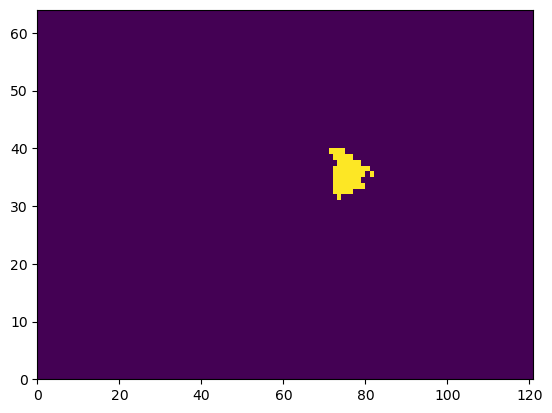

In [183]:
plt.pcolormesh(durations[3])

In [164]:
diffs = xr.concat(diffs,dim='exp')
diffs_percent = xr.concat(diffs_percent,dim='exp')
corrs = xr.concat(corrs,dim='exp')

In [165]:
diffs.to_netcdf('diffs_models_extremes/diffs_lens_ws.nc')
diffs_percent.to_netcdf('diffs_models_extremes/diffs_percent_lens_ws.nc')
corrs.to_netcdf('corrs_models_extremes/corrs_percent_lens_ws.nc')

# just for PT

In [187]:
diffs = []
diffs_percent = []
corrs = []
for filei in range(len(names_exps)):
    durations_da  = xr.open_dataset(f'{path_spells}ws_{name_exp_temp}.nc')
    name_exp_temp = names_exps[filei]
    
    df_temp = dic_labels_lens2[name_exp_temp]['1994':'2023']
    temp_temp = durations_da.sel(time=df_temp[df_temp['WR']==1].index)
    composite_past = temp_temp.sum('time')/30
    
    df_temp = dic_labels_lens2[name_exp_temp]['2071':'2100']
    temp_temp = durations_da.sel(time=df_temp[df_temp['WR']==1].index)
    composite_present = temp_temp.sum('time')/30
    
    diff = composite_present-composite_past
    diff_percent = diff/composite_past
    
    diffs.append(diff)
    diffs_percent.append(diff_percent)

    df_temp = dic_labels_lens2[name_exp_temp].loc['1948':]
    temp_temp = durations_da.sel(time=df_temp[df_temp['WR']==1].index)
    
    yearly_anoms = temp_temp.groupby('time.year').sum(dim='time')
    
    corr_temp = calculate_pixel_correlation_vectorized(\
        yearly_anoms.sel(year=slice('2024','2100')).start_durations, \
        dic_yearly_freqs[name_exp_temp].loc['2024':'2100'])
    corrs.append(corr_temp)

/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: RuntimeWarning: invalid value encountered in divide
  correlation_coeffs = covariance / (data_std.values * time_std)
/glade/derecho/scratch/jhayron/tmp/ipykernel_32236/1076322842.py:24: R

In [188]:
diffs = xr.concat(diffs,dim='exp')
diffs_percent = xr.concat(diffs_percent,dim='exp')
corrs = xr.concat(corrs,dim='exp')

In [189]:
diffs.to_netcdf('diffs_models_extremes/diffs_lens_ws_pt.nc')
diffs_percent.to_netcdf('diffs_models_extremes/diffs_percent_lens_ws_pt.nc')
corrs.to_netcdf('corrs_models_extremes/corrs_percent_lens_ws_pt.nc')

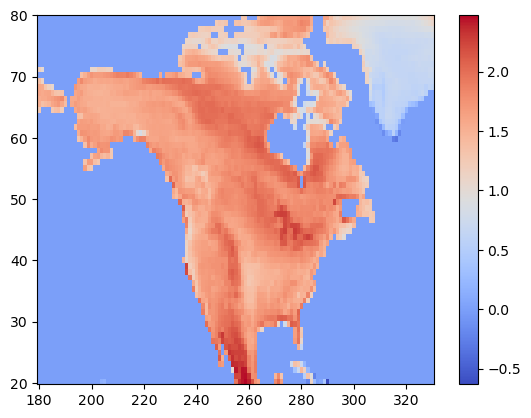

In [192]:
plt.pcolormesh(corr_temp.lon,corr_temp.lat,diffs.start_durations.mean('exp'),cmap='coolwarm')
plt.colorbar()

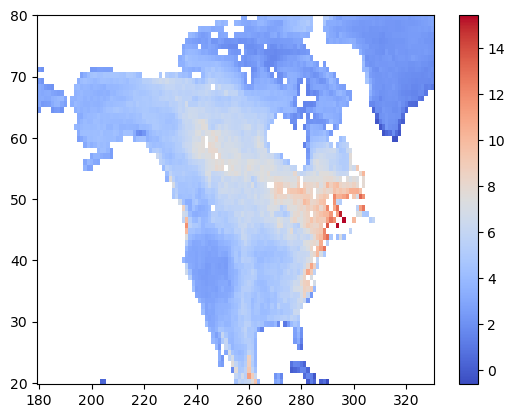

In [191]:
plt.pcolormesh(corr_temp.lon,corr_temp.lat,diffs_percent.start_durations.mean('exp'),cmap='coolwarm')
plt.colorbar()

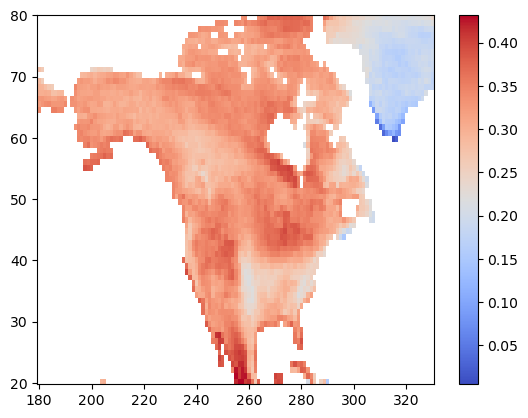

In [193]:
plt.pcolormesh(corr_temp.lon,corr_temp.lat,corrs.mean('exp').correlation,cmap='coolwarm')
plt.colorbar()